In [1]:
from pathlib import Path
import typing as T
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy
import xarray as xr

def plot_region(ax, name: str, centre: T.Tuple[float, float], res: T.Tuple[float, float], size: T.Tuple[int, int], pole: T.Tuple[float, float]=(90,180), rim: int=9, halo: T.Tuple[int, int]=(7,7), **kwargs):
    """
    Plots a LAM region, including its rim and halo
    """
    
    draw_box_centre_size(ax, name, centre, res, size, pole, **kwargs)
    
    rim_size = [size[0]-rim*2, size[1]-rim*2]
    draw_box_centre_size(ax, name + '_rim', centre, res, rim_size, pole, ls='--', **kwargs)
    
    halo_size = [size[0]+halo[0]*2, size[1]+halo[1]*2]
    draw_box_centre_size(ax, name + '_halo', centre, res, halo_size, pole, ls=':', **kwargs)
    
def draw_box_centre_size(ax, name: str, centre: T.Tuple[float, float], res: T.Tuple[float, float], size: T.Tuple[int, int], pole: T.Tuple[float, float]=(90,180), **kwargs):
    """
    Draws a box given its centre and size
    """
    size_lon = res[1] * size[1]
    size_lat = res[0] * size[0]

    draw_box_corners(ax, name, corners=[centre[1]-size_lon/2, centre[1]+size_lon/2, centre[0]-size_lat/2, centre[0]+size_lat/2], pole=pole, **kwargs)
    
def draw_box_corners(ax, name: str, corners: T.Tuple[float, float, float, float], pole: T.Tuple[float, float]=(90,180), **kwargs):
    """
    Draws a box given its corners
    """
    x0,x1,y0,y1 = corners
    
    lons = numpy.linspace(x0,x1)
    lats = numpy.linspace(y0,y1)
        
    crs = ccrs.RotatedGeodetic(pole[1], pole[0])
    ax.plot(lons, [y0]*lons.size, transform=crs, **kwargs, label=name) 
    ax.plot(lons, [y1]*lons.size, transform=crs, **kwargs) 
    ax.plot([x0]*lats.size, lats, transform=crs, **kwargs) 
    ax.plot([x1]*lats.size, lats, transform=crs, **kwargs)

In [2]:
ERA5_temp_file = Path('/g/data/rt52/era5/single-levels/monthly-averaged/tmax/2024/tmax_era5_wamo_sfc_20240501-20240531.nc')

In [3]:
ERA5_temp = xr.open_dataset(ERA5_temp_file)
ERA5_temp

<xarray.Dataset> Size: 2MB
Dimensions:    (longitude: 720, latitude: 361, time: 1)
Coordinates:
  * longitude  (longitude) float32 3kB -180.0 -179.5 -179.0 ... 179.0 179.5
  * latitude   (latitude) float32 1kB 90.0 89.5 89.0 88.5 ... -89.0 -89.5 -90.0
  * time       (time) datetime64[ns] 8B 2024-05-01
Data variables:
    tmax       (time, latitude, longitude) float64 2MB ...
Attributes:
    Conventions:  CF-1.6
    history:      2024-09-02 07:38:20 UTC+1000 by era5_replication_tools-1.12...
    license:      Licence to use Copernicus Products: https://apps.ecmwf.int/...
    summary:      ERA5 is the fifth generation ECMWF atmospheric reanalysis o...
    title:        ERA5 single-levels monthly-averaged period_corresponding_to...

In [4]:
CENTRE=[-12.0,132.0]
RES=[0.0198,0.0198]
SIZE=[200,200]

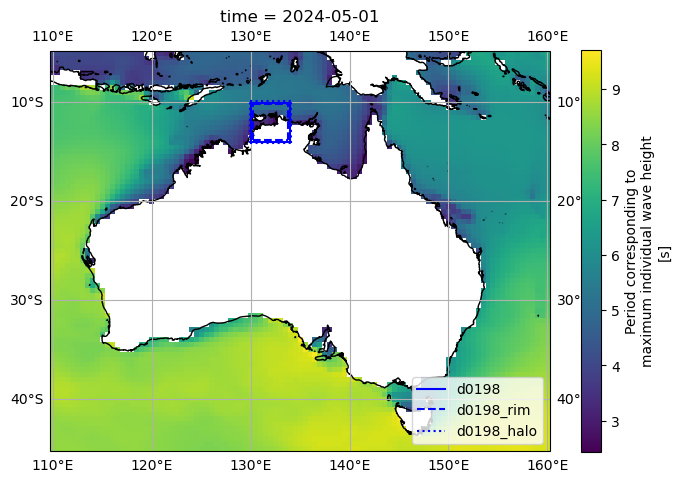

In [5]:
plt.figure(figsize=(7,7))
ax = plt.axes(projection=ccrs.PlateCarree())
ERA5_temp.tmax.sel(longitude=slice(110,160),latitude=slice(-5,-45)).plot(
    ax=ax,
    cbar_kwargs={"orientation": "vertical", "shrink": 0.6, "aspect": 20})
ax.gridlines(draw_labels=True)

plot_region(ax, 'd0198', centre=CENTRE, res=RES, size=SIZE, color='b')
ax.coastlines('10m')
ax.legend(loc='lower right');
plt.tight_layout()

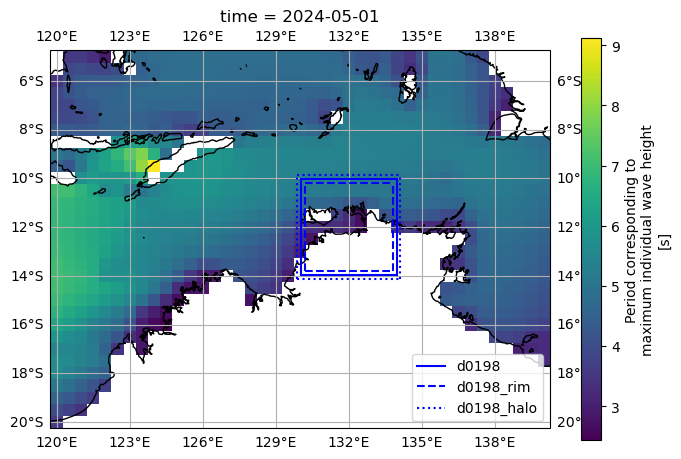

In [6]:
plt.figure(figsize=(7,7))
ax = plt.axes(projection=ccrs.PlateCarree())
ERA5_temp.tmax.sel(longitude=slice(120,140),latitude=slice(-5,-20)).plot(
    ax=ax,
    cbar_kwargs={"orientation": "vertical", "shrink": 0.6, "aspect": 20})
ax.gridlines(draw_labels=True)

plot_region(ax, 'd0198', centre=CENTRE, res=RES, size=SIZE, color='b')
ax.coastlines('10m')
ax.legend(loc='lower right');
plt.tight_layout()

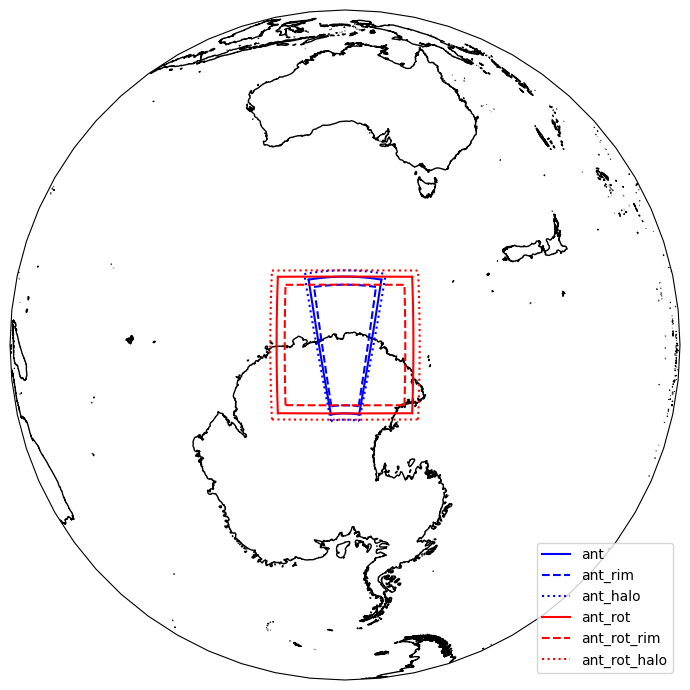

In [22]:
# Rotated pole example
CENTRE=[-68.0,130.0]
RES=[0.135,0.135]
SIZE=[150,150]
plt.figure(figsize=(7,7))
ax = plt.axes(projection=ccrs.NearsidePerspective(central_latitude=-68, central_longitude=130))

plot_region(ax, 'ant', centre=CENTRE, res=RES, size=SIZE, color='b')
plot_region(ax, 'ant_rot', centre=[0,0], res=RES, size=SIZE, pole=[90+68,180+130], color='r')

ax.set_global()
ax.coastlines('10m')
ax.legend(loc='lower right');
plt.tight_layout()